In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd /content/drive/My\ Drive/spngp

/content/drive/My Drive/spngp


In [3]:
! pip install GPy gpyopt xgboost

     |████████████████████████████████| 1.0MB 2.6MB/s 
     |████████████████████████████████| 61kB 6.9MB/s 
     |████████████████████████████████| 71kB 6.0MB/s 
  Created wheel for GPy: filename=GPy-1.9.9-cp36-cp36m-linux_x86_64.whl size=2633927 sha256=828998e4eb22800adf8d823335b052d6b3a88829dfda083fdaee3cfbfe8e3858
  Stored in directory: /root/.cache/pip/wheels/5d/36/66/2b58860c84c9f2b51615da66bfd6feeddbc4e04d887ff96dfa
  Created wheel for gpyopt: filename=GPyOpt-1.2.6-cp36-none-any.whl size=83623 sha256=833e7720eadc2a8fc4b051258425c648d7f8a1f05b3f4f75d5523e96b256ddde
  Stored in directory: /root/.cache/pip/wheels/b2/00/69/cfa967a125cf25e66f644be6193ad6f0edf231147879ad714f
  Created wheel for paramz: filename=paramz-0.9.5-cp36-none-any.whl size=102552 sha256=7bf2b56c2915a023399eac4344d6be43899acbbbe2cfbffe3e319d4cfdadd4f0
  Stored in directory: /root/.cache/pip/wheels/c8/4a/0e/6e0dc85541825f991c431619e25b870d4b812c911214690cf8
Successfully built GPy gpyopt paramz


In [0]:
import numpy as np
import GPy
import GPyOpt
import matplotlib.pyplot as plt
from sklearn.svm import SVR
import sklearn.datasets
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
import time
%matplotlib inline
import pandas as pd
import sys


In [0]:
data = pd.read_csv('spngp/datasets/ccpp/ccpp.csv')
data = pd.DataFrame(data).dropna() # miss = data.isnull().sum()/len(data)
dmean, dstd = data.mean(), data.std()
data = (data-dmean)/dstd

# GPSPN on full data
train = data.sample(frac=0.8, random_state=58)
test  = data.drop(train.index)
x, y = train.iloc[:, :-1].values, train.iloc[:, -1].values.reshape(-1,1)

In [0]:
x_test, y_test = test.iloc[:, :-1].values, test.iloc[:, -1].values.reshape(-1,1)

In [7]:
print(x_test.shape)
print(y_test.shape)

(1895, 4)
(1895, 1)


In [8]:
print(x.shape)
print(y.shape)

(7578, 4)
(7578, 1)


In [0]:
X = np.array(x)
y = np.array(y)
X_test = np.array(x_test)
y_test = np.array(y_test)

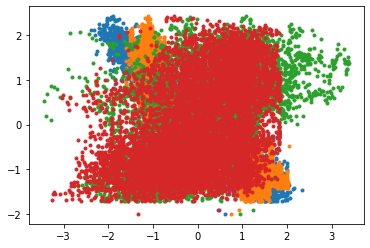

In [10]:
plt.plot(X, y, '.')
plt.show()

In [0]:
kernel = GPy.kern.RBF(input_dim = 4, variance = 1.5, lengthscale = 2)

In [23]:
start = time.time()
model = GPy.models.GPRegression(X,y,kernel)
model.optimize(messages=True)
mean,variance = model.predict(x_test)
time_gp = time.time()-start

In [24]:
print(time_gp)

953.0531625747681


In [25]:
mn = (mean.ravel() * dstd.iloc[-1]) + dmean.iloc[-1]
mu_t = (test.iloc[:, -1]*dstd.iloc[-1]) + dmean.iloc[-1]
sqe = (mn - mu_t.values)**2
rmse = np.sqrt(sqe.sum()/len(test))
print(rmse)

3.894151370888791


In [26]:
start2 = time.time()
model = GPy.models.SparseGPRegression(X,y,kernel,num_inducing=1000)
model.optimize(messages=True)
mean2,variance2 = model.predict(x_test)
time_sgp = time.time()-start2

In [27]:
print(time_sgp)

5499.846234321594


In [28]:
mn2 = (mean2.ravel() * dstd.iloc[-1]) + dmean.iloc[-1]
mu_t2 = (test.iloc[:, -1]*dstd.iloc[-1]) + dmean.iloc[-1]
sqe2 = (mn2 - mu_t2.values)**2
rmse_inducing = np.sqrt(sqe2.sum()/len(test))
print(rmse_inducing)

3.894495460984587
